In [1]:
%env THEANO_FLAGS="device=gpu2"
import numpy as np
import theano
theano.config.floatX='float32'
import theano.tensor as T
import lasagne
from lasagne.layers import *
import pickle
from tqdm import tqdm_notebook
from librosa import load, logamplitude
from librosa.feature import melspectrogram
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.style.use('classic')

env: THEANO_FLAGS="device=gpu2"


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: GeForce GTX 1080 (CNMeM is enabled with initial size: 22.0% of memory, cuDNN 5110)


In [3]:
files = pickle.load(open("spectrograms_wirh_names_for_nn", "rb"))
names = [files[i][0] for i in range(len(files))]
spectrograms = [files[i][1] for i in range(len(files))]
del files

In [10]:
data_answ = []
for i in tqdm_notebook(range(len(names))):
    strs = names[i].split("|")
    a = np.zeros((88, len(strs)*3))    
    for j in range(len(strs)*3):
        notes = strs[j // 3][:-4].split(",")
        for k in range(len(notes)):
            a[int(notes[k]) - 21][j] = 1
    data_answ.append(a)

In [18]:
max_len = max(list(zip(*list(map(np.shape,data_answ))))[1])
answ_tensor = np.zeros((len(data_answ),88,max_len),dtype='uint8')
max_len_spec = max(list(zip(*list(map(np.shape,spectrograms))))[1])
spec_tensor = np.zeros((len(spectrograms),128,max_len_spec),dtype='float32')

In [48]:
for i in tqdm_notebook(range(len(data_answ))):
    for j in range(len(data_answ[i])):
        for x in range(len(data_answ[i][j])):
            if data_answ[i][j][x] == 1:
                answ_tensor[i][j][x] = 1

In [21]:
for i in tqdm_notebook(range(len(spectrograms))):
    for j in range(len(spectrograms[i])):
        for x in range(len(spectrograms[i][j])):
            spec_tensor[i][j][x] = spectrograms[i][j][x]
        for n in range(x, len(spec_tensor[i][j])):
            spec_tensor[i][j][n] = -80.0

In [22]:
del spectrograms

In [23]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(spec_tensor/80.,answ_tensor,train_size=50000)

/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
list(map(np.shape,[X_test,y_test]))

[(11201, 128, 77), (11201, 88, 21)]

In [25]:
input_X, target_y = T.tensor3("X", dtype='float32'), T.tensor3("y", dtype='int32')

In [49]:
nn = lasagne.layers.InputLayer(shape=(None, X_train.shape[1], X_train.shape[2]), input_var=input_X/80.) 
print(nn.output_shape)
nn = lasagne.layers.Conv1DLayer(nn, 64, 6)
print(nn.output_shape)
nn = lasagne.layers.MaxPool1DLayer(nn, 3)
print(nn.output_shape)
nn = lasagne.layers.Conv1DLayer(nn, 64, 4) 
print(nn.output_shape)
nn = lasagne.layers.Conv1DLayer(nn, 88, 1,nonlinearity=T.nnet.sigmoid)
print(nn.output_shape)


assert nn.output_shape[1:] == y_train.shape[1:],"wrong output shape"

(None, 128, 77)
(None, 64, 72)
(None, 64, 24)
(None, 64, 21)
(None, 88, 21)


In [50]:
y_pred  = lasagne.layers.get_output(nn)
loss = lasagne.objectives.binary_crossentropy(y_pred, target_y).mean()
weights = lasagne.layers.get_all_params(nn)
updates_sgd = lasagne.updates.adam(loss, weights)

train_fun = theano.function([input_X, target_y], loss, allow_input_downcast=True, updates=updates_sgd)
test_fun = theano.function([input_X, target_y], loss, allow_input_downcast=True)

predict_probas = theano.function([input_X],y_pred)

In [ ]:
batch_size = 15
epochs = 1000
n_examples = X_train.shape[0]
n_batches = n_examples // batch_size

from tqdm import tnrange
for epoch in tnrange(epochs):
    for batch in tnrange(n_batches):
        x_batch = X_train[batch*batch_size: (batch+1) * batch_size]
        y_batch = y_train[batch*batch_size: (batch+1) * batch_size]
        loss = train_fun(x_batch,y_batch)
    print(loss)

0.019522649021340113


0.019503799689002583


0.019482819494514518


0.019439021139255178


0.01942095262681435


0.019359717047611538


0.019340780798293773


0.019300889905470284


0.01927491451306464


0.019236794918954966


0.019192413039356586


0.01918841260281329


0.01917105377132466


0.019154739278933658


0.019153394183006916


0.019132348078641857


0.01907351365485046


0.019078185351295227


0.01906983754899957


0.019074141751499425


0.019082655708021444


0.019044904589379248


0.01902166478882333


0.018995040965531323


0.01896806911807373


0.018952230726897962


0.01894686906007915


0.018947536417614007


0.018941851863345776


0.018958310010549772


0.01891815303827965


0.018898592814272884


0.018878950201215067


0.018863360765620413


0.018838001652945868


0.0187987303200888


0.018810410482870778


0.018804365818944752


0.01878397475576036


0.018767053654947366


0.018750537703655847


0.0187013485067934


0.01870826313082964


0.01869042475290833


0.018644841628320377


0.018656881359476293


0.0186282364128336


0.01859774589308509


0.018615354512992115


0.01859517625289177


0.01857209509156605


0.018594221330534167


0.018572820909180107


0.018517717503740188


0.018510345572664615


0.018494697419276486


0.01846229172265542


0.01842549471375447


0.018380948031776027


0.018380273061314806


0.01835031080147792


0.018335127647271583


0.0183007688885528


0.018291126649837473


0.018275891430880493


0.018259200783101497


0.018271896500420125


0.018257637315965747


0.01824045338696461


0.018144750195621402


0.018127554782061683


0.01812302654279217


0.018121677656223585


0.018112984507610404


0.018117444717235972


0.018108984302122377


0.01812160133991905


0.018087046095436366


0.018064572480291086


0.01800250380997484


0.01803109175312838


0.018031770548821862


0.018037708962270922


0.018017322461218694


0.018010118776601997


0.017977157452033713


0.017996387681007336


0.018006044133846797


0.017995659001960373


0.01800989162712003


0.017990004733654936


0.017969820071611613


0.017982227447942953


0.0179718302922512


0.018001103974625364


0.01796346433673868


0.01797320873896183


0.017974937201855216


0.01797828243874901


0.017996571151716555


0.01799218668203676


0.01798303523130536


0.018027661221386666


0.0179822400694638


0.017993438815865674


0.017966286918073775


0.017955363978045306


0.01796283802704492


0.01798242380775424


0.018007980580722716


0.017973044854516264


0.017979427873780138


0.01799409705989402


0.01797368900388226


0.017980355385783468


0.017984155536954


0.017971357346673916


0.017981704491096193


0.01800815906606876


0.017995296230678946


0.017995199772997128


0.017968324834157105


0.018004861083787453


0.018002916325666505


0.01799870974426057


0.017994854494192535


0.0180180646528951


0.017991829547419572


0.017980167896337232


0.017990264735360004


0.01801156330338145


0.017993003459790064


0.018047699941513395


0.018018640540537444


0.018016402096140968


0.01806232800294017


0.01799457802517904


0.018017812305492615


0.017994880893196587


0.01801120238030394


0.017965903106290045


0.017971241847489314


0.017998473153311864


0.01797867540838663


0.017958630715834267


0.017990431276073904


0.018004675647423696


0.01795066910541431


0.017941542018672565


0.017962655461830908


0.017978248909242205


0.017986826494712272


0.01794670565207124


0.017963529031547232


0.01795454289529695


0.01795687280388885


0.017992685799011834


0.017977829958191742


0.017998146121350884


0.017990857422178045


0.017985153061477903


0.01796459568239621


0.01794929455302365


0.017960192888145883


0.017973807000899827


0.017971066972837905


0.018033954655036415


0.01795714931643822


0.01794756044227117


0.017908588639224166


0.017954190003026897


0.01791281910036276


0.017944808011430433


0.01794088502954638


0.01793055733791054


0.017942170766726034


0.01790142941659902


0.01792647483488008


0.017912604426117383


0.017925616725896504


0.017919217795305295


0.017920411934703125


0.017905167998509892


0.017856718028150798


0.01785488354688834


0.017871156365104324


0.017936566104830385


0.017854833120268393


0.017937912181304708


0.01792384327887043


0.017887143042040664


0.017808258908706884


0.017832501338727397


0.017844817090660298


0.017799846043363425


0.01785372414172694


0.017814456117534423


0.017829912745032848


0.017861312302778282


0.017830219536552432


0.01782767551930631


0.017835339494829152


0.017841751882307157


0.017829953382123776


0.017783229600287404


0.0177823039892975


0.017773095267265438


0.017729498763946017


0.017721919290977474


0.017758766777033596


0.017724433395680132


0.017725428363671962


0.017746586658858202


0.017711547654668897


0.017739551690699157


0.0176859960639409


0.017748057593623447


0.017729284682546233


0.017753689213562223


0.017716294965186015


0.017653008154010198


0.01766473750372859


0.017668367766122746


0.01766131614588306


0.01766626823448693


0.017617994645415334


0.017700581827256593


0.017693688323910488


0.017642291683767856


0.017612720364236428


0.01764232624338616


0.017585920420511752


0.017614669613957367


0.017628626377470962


0.017590601669352685


0.01759311638383819


0.017583354018147493


0.017589372513267594


0.017591501272498627


0.017563073422012982


0.017618793087389683


0.01756259479179711


0.017593777978817473


0.017586434561132895


0.017606267065831644


0.017559757943626114


0.01755678460087586


0.01754801337870607


0.01752648666810267


0.017600131242144185


0.01756720560210538


0.017535959691724917


0.01752482814483198


0.017555661734140207


0.01753208061760912


0.017508650350957437


0.017500925184792317


0.017484114852425466


0.017507017500038854


0.01749375893487082


0.017506914569616134


0.01749065496666406


0.017495443916586046


0.017476256903867768


0.01747991855456099


0.01749119707510547


0.01746488735564588


0.017478593105654878


0.01748761068734183


0.01750534803088967


0.017510185042430265


0.01749691742001872


0.017493802800792324


0.01748395270743936


0.017478335800823742


0.017458154154709037


0.01748187275054208


0.017484138825426796


0.017474127953311117


0.01749508284015861


0.01745231398291393


0.017484692415427657


0.01748462423637149


0.017494223564362386


0.017482860774650173


0.01747904539092195


0.01748297971060303


0.01746095387132858


0.017498567757445727


0.01746271520459643


0.017456236039263252


0.01744844413570959


0.017481592134173107


0.017465467019811384


0.01745740292939294


0.017464532894558824


0.017466257344023548


0.017461648913132323


0.017433096490113077


0.01741879742317261


0.01744252186347237


0.017487028415686376


0.01744232151870305


0.017431477596068706


0.01741762697475952


0.017416983196901877


0.017449618810466496


0.01742160318050899


0.01740697275962663


0.017370762814686153


0.017419348134291197


0.017398233676189236


0.017389206924791664


0.017438531968805713


0.01741144350488426


0.0174169916854168


0.017384935145456602


0.01741950881665116


0.017399521129086264


0.017400570792080766


0.017373441593801626


0.017419918857812924


0.01741332153555307


0.01740353839515299


0.017399272751368915


0.017435166999197865


0.017382698528490226


0.017365527126843167


0.017392350444946025


0.017386348489231457


0.01737090053081569


0.017390542863329354


0.01740199200079078


0.017382362706881177


0.017453020697418428


0.01737804181934407


0.017386555012579026


0.017417984037634553


0.017354931447133095


0.017349895300216196


0.017378365485390977


0.017353374846888432


0.017362843829239933


0.017392005241009954


0.017359274688175372


0.01735060681341477


0.01738675968978635


0.01743157538384008


0.017349343181803364


0.017306465869375367


0.01732547286159834


0.01733428815380788


0.017311304973346868


0.017346113574996904


0.01734499420296678


0.017342582671442307


0.01735127946657607


0.01742224135153475


0.017383713081283354


0.01735744291909277


0.017391302081921727


0.01735135883003967


0.01734141665047019


0.017347420553439255


0.017337043892309105


0.017423346108874613


0.017331286215322008


0.017411893448769866


0.01734295231578708


0.017350651811358576


0.017338614218340744


0.017420556315182936


0.017390350584104493


0.017305464419711408


0.017301759754234407


0.0173138988013471


0.017421522503537644


0.017399404362964083


0.01740392461121047


0.01741494382698337


0.017396211804302737


0.01737444642448934


0.017390871905294963


0.01738643948799756


0.01737742787816992


0.01738985638367387


0.01731254795386169


0.017277380777129266


0.01729212548155413


0.017294223843624206


0.0172980843259283


0.01730114496246361


0.017302508166320056


0.017364684793668133


0.017345839008836086


0.017298076486492724


0.017362152592296523


In [1]:
import pickle
pickle.dump(lasagne.layers.get_all_param_values(nn), open('third_nn', 'wb'),protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'lasagne' is not defined

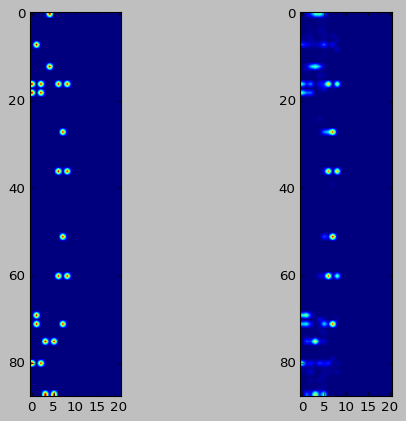

In [54]:
b = 11
plt.subplot(1, 2, 1)
plt.imshow(y_test[b])
plt.subplot(1, 2, 2)
plt.imshow(predict_probas(X_test[b:b+1])[0])